In [13]:
from naslib.search_spaces import NasBench201SearchSpace, NasBench101SearchSpace
from naslib.utils import get_dataset_api, setup_logger, get_zc_benchmark_api
from naslib.utils import get_train_val_loaders, get_project_root
from fvcore.common.config import CfgNode
from tqdm import tqdm
from naslib.defaults.predictor_evaluator import PredictorEvaluator
from naslib.predictors import XGBoost
from naslib.utils.encodings import EncodingType
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.stats import kendalltau, spearmanr
import random
from tqdm import tqdm
from naslib.search_spaces.core.query_metrics import Metric
from naslib.predictors import ZeroCost
from naslib.search_spaces import NasBench201SearchSpace

In [3]:
## Zero cost proxies for performance prediction
def evaluate_predictions(y_true, y_pred):
  res = {}
  res['kendalltau'] = kendalltau(y_true, y_pred)[0]
  res['spearmanr'] = spearmanr(y_true, y_pred)[0]

  return res

def iterate_whole_searchspace(search_space, dataset_api, seed=None, shuffle=False):
  # Note - for nb301, this method only returns the training set architectures
  arch_iter = search_space.get_arch_iterator(dataset_api)
  if shuffle:
    arch_iter = list(arch_iter)
    rng = random if seed is None else random.Random(seed)
    rng.shuffle(arch_iter)

  for arch_str in arch_iter:
    yield arch_str


def sample_arch_dataset(search_space, dataset, dataset_api, data_size=None, arch_hashes=None, seed=None, shuffle=False):
  xdata = []
  ydata = []
  train_times = []
  arch_hashes = arch_hashes if arch_hashes is not None else set()

  # Cloning NASLib objects takes some time - this is a hack-... speedup so that
  # we can quickly get all architecture hashes and accuracies in a searchspace.
  # However, not all methods are available - e.g. you can't encode the architecture
  search_space = search_space.clone()
  search_space.instantiate_model = False
  arch_iterator = iterate_whole_searchspace(search_space, dataset_api, shuffle=shuffle, seed=seed)

  # iterate over architecture hashes
  for arch in tqdm(arch_iterator):
      if data_size is not None and len(xdata) >= data_size:
        break

      if arch in arch_hashes:
          continue

      arch_hashes.add(arch)
      search_space.set_spec(arch)

      # query metric for the current architecture hash
      accuracy = search_space.query(metric=Metric.TRAIN_ACCURACY, dataset=dataset, dataset_api=dataset_api)
      train_time = search_space.query(metric=Metric.TRAIN_TIME, dataset=dataset, dataset_api=dataset_api)

      xdata.append(arch)
      ydata.append(accuracy)
      train_times.append(train_time)

  return [xdata, ydata, train_times], arch_hashes

def encode_archs(search_space, arch_ops, encoding=None, verbose=True):
    encoded = []

    for arch_str in tqdm(arch_ops, disable=not verbose):
        arch = search_space.clone()
        arch.set_spec(arch_str)

        arch = arch.encode(encoding) if encoding is not None else arch
        encoded.append(arch)

    return encoded

def eval_zcp(model, zc_name, data_loader):
    model = encode_archs(NasBench201SearchSpace(), [model], verbose=False)[0]
    model.parse()
    zc_pred = ZeroCost(method_type=zc_name)
    res = zc_pred.query(graph=model, dataloader=data_loader)

    return {zc_name: res}

In [64]:
dataset = 'cifar100' #'ImageNet16-120' 
seed = 2
benchmark = 'nasbench201'
num_archs_train = 1000
num_archs_test = 1000
zc_proxies = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']

In [65]:
def get_model_inputs(dataset, archs, zc_proxies):
  inputs = []
  for arch in archs:
      inputs.append([dataset[str(arch)].get(metric_name, 0)['score'] for metric_name in zc_proxies])
  return inputs

In [78]:
def get_test_train_samples(dataset):
    seed = 2
    pred_dataset = dataset
    # get data from api
    pred_api = get_dataset_api(search_space=benchmark, dataset=dataset)
    train_size = num_archs_train
    test_size = num_archs_test

    train_sample, train_hashes = sample_arch_dataset(NasBench201SearchSpace(), pred_dataset, pred_api, data_size=train_size, shuffle=True, seed=seed)
    test_sample, _ = sample_arch_dataset(NasBench201SearchSpace(), pred_dataset, pred_api, arch_hashes=train_hashes, data_size=test_size, shuffle=True, seed=seed+1)

    xtrain, ytrain, _ = train_sample
    xtest, ytest, _ = test_sample

    return xtrain, xtest, ytrain, ytest
        

In [66]:
# Create configs required for get_train_val_loaders
config_dict = {
      'dataset': dataset, # Dataset to loader: can be cifar10, cifar100, ImageNet16-120
      'data': str(get_project_root()) + '/data', # path to naslib/data where cifar is saved
      'search': {
          'seed': seed, # Seed to use in the train, validation and test dataloaders
          'train_portion': 0.7, # Portion of train dataset to use as train dataset. The rest is used as validation dataset.
          'batch_size': 32, # batch size of the dataloaders
      }
  }
config = CfgNode(config_dict)

# Get the dataloaders
train_loader, val_loader, test_loader, train_transform, valid_transform = get_train_val_loaders(config)

seed = seed
pred_dataset = dataset
# get data from api
zc_api = get_zc_benchmark_api(benchmark, pred_dataset)
pred_api = get_dataset_api(search_space=benchmark, dataset=dataset)
train_size = num_archs_train
test_size = num_archs_test

train_sample, train_hashes = sample_arch_dataset(NasBench201SearchSpace(), pred_dataset, pred_api, data_size=train_size, shuffle=True, seed=seed)
test_sample, test_hashes = sample_arch_dataset(NasBench201SearchSpace(), pred_dataset, pred_api, arch_hashes=train_hashes, data_size=test_size, shuffle=True, seed=seed+1)

xtrain, ytrain, _ = train_sample
xtest, ytest, _ = test_sample

Files already downloaded and verified
Files already downloaded and verified


1000it [00:00, 51211.25it/s]
1070it [00:00, 60575.33it/s]


In [67]:
# prepare the inputs and targets based on the modified combined_data_list
inputs_train = get_model_inputs(zc_api, xtrain, zc_proxies)
inputs_test = get_model_inputs(zc_api, xtest, zc_proxies)

## XGBoost

In [68]:
from xgboost import XGBRegressor
import numpy as np
from scipy.stats import kendalltau, spearmanr

In [69]:
def evaluate_predictions(y_true, y_pred):
  res = {}
  res['kendalltau'] = kendalltau(y_true, y_pred)[0]
  res['spearmanr'] = spearmanr(y_true, y_pred)[0]

  return res

In [113]:
# Function to train the model with incremental features
def train_with_incremental_features(benchmark, zc_proxies):
    metrics_dataset = {}  # To store metrics for each iteration

    for dataset in zc_proxies.keys():
        metrics_all = []
        for i in range(1, len(zc_proxies[dataset]) + 1):  # Iterate over increasing number of features
            # Select the first i features from zc_proxies
            zc_api = get_zc_benchmark_api(benchmark, dataset)
            selected_proxies = zc_proxies[dataset][:i]
            xtrain, xtest, ytrain, ytest = get_test_train_samples(dataset)

            # Prepare inputs based on selected features
            inputs_train = np.array(get_model_inputs(zc_api, xtrain, selected_proxies))
            inputs_test = np.array(get_model_inputs(zc_api, xtest, selected_proxies))

            # Initialize and train the model
            model = XGBRegressor()
            model.fit(inputs_train, ytrain)

            # Make predictions
            predictions = model.predict(inputs_test)

            # Evaluate predictions
            metrics = evaluate_predictions(ytest, predictions)
            metrics_all.append(metrics)
        metrics_dataset[dataset] = metrics_all

    return metrics_dataset

In [124]:
# cifar 10
zc_proxies_cifar10 = ['synflow', 'nwot', 'params', 'flops', 'l2_norm', 'jacov', 'epe_nas', 'snip', 'grad_norm', 'grasp', 'fisher', 'zen', 'plain']
# cifar 100
zc_proxies_cifar100 = ['synflow', 'nwot', 'params', 'flops', 'l2_norm', 'snip', 'grad_norm', 'jacov', 'grasp', 'fisher', 'epe_nas', 'zen', 'plain']
# imagenet
zc_proxies_imagent = ['nwot', 'synflow', 'jacov', 'l2_norm', 'params', 'flops', 'snip', 'grad_norm', 'grasp', 'fisher', 'zen', 'epe_nas', 'plain']

zc_proxies = {"cifar10": zc_proxies_cifar10, "cifar100": zc_proxies_cifar100, "ImageNet16-120": zc_proxies_imagent }

benchmark = 'nasbench201'
metrics_all = train_with_incremental_features(benchmark, zc_proxies)

1000it [00:00, 48475.05it/s]
1070it [00:00, 57394.50it/s]
1000it [00:00, 58407.54it/s]
1070it [00:00, 61664.84it/s]
1000it [00:00, 57974.01it/s]
1070it [00:00, 62270.61it/s]
1000it [00:00, 57656.83it/s]
1070it [00:00, 56488.59it/s]
1000it [00:00, 57042.08it/s]
1070it [00:00, 56954.56it/s]
1000it [00:00, 57320.38it/s]
1070it [00:00, 56445.96it/s]
1000it [00:00, 53191.43it/s]
1070it [00:00, 57654.03it/s]
1000it [00:00, 57434.98it/s]
1070it [00:00, 59921.03it/s]
1000it [00:00, 55444.28it/s]
1070it [00:00, 60768.08it/s]
1000it [00:00, 56504.16it/s]
1070it [00:00, 60860.38it/s]
1000it [00:00, 56743.43it/s]
1070it [00:00, 61746.29it/s]
1000it [00:00, 57856.46it/s]
1070it [00:00, 61146.46it/s]
1000it [00:00, 56990.15it/s]
1070it [00:00, 54953.05it/s]
1000it [00:00, 51842.97it/s]
1070it [00:00, 51351.38it/s]
1000it [00:00, 56208.09it/s]
1070it [00:00, 60952.13it/s]
1000it [00:00, 53134.83it/s]
1070it [00:00, 54874.43it/s]
1000it [00:00, 53240.05it/s]
1070it [00:00, 57180.24it/s]
1000it [00:00,

cifar10
cifar100
ImageNet16-120


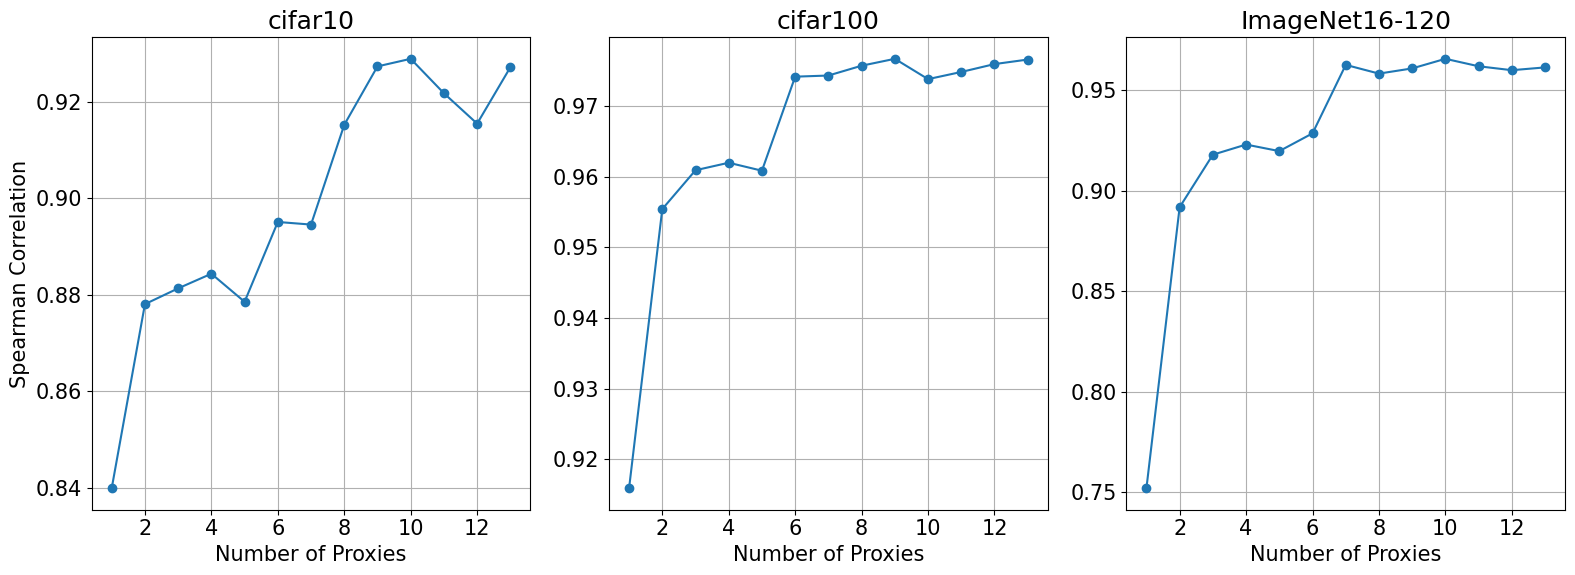

In [137]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 15})  # Update all font sizes

for i, dataset in enumerate(metrics_all.keys()):
    print(dataset)
    plt.subplot(1, 3, i + 1)
    plt.plot(range(1, len(metrics_all[dataset]) + 1), [m['spearmanr'] for m in metrics_all[dataset]], marker='o', linestyle='-')
    plt.title(f'{dataset}')
    plt.xlabel('Number of Proxies')
    if i == 0:
        plt.ylabel('Spearman Correlation')
    plt.grid(True)

plt.tight_layout()
plt.savefig('xgboost_num_proxies_vs_correlation.png', dpi=500)
# plt.show()

## Tune XGBoost

In [120]:
benchmark = 'nasbench201'
dataset = 'cifar10'
xtrain, xtest, ytrain, ytest = get_test_train_samples(dataset)

zc_proxies = ['synflow', 'nwot', 'params', 'flops', 'l2_norm', 'jacov', 'epe_nas', 'snip', 'grad_norm', 'grasp', 'fisher', 'zen', 'plain']

zc_api = get_zc_benchmark_api(benchmark, dataset)
# Prepare inputs based on selected features
inputs_train = np.array(get_model_inputs(zc_api, xtrain, zc_proxies))
inputs_test = np.array(get_model_inputs(zc_api, xtest, zc_proxies))

1000it [00:00, 55527.22it/s]
1070it [00:00, 60401.68it/s]


In [1]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define a parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'subsample': [0.3, 0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2, 10, 20],
    'sampling_method': ['uniform', 'gradient_based'],
    'alpha': [0, 1, 5],
    'tree_method': ['auto', 'exact', 'approx', 'hist'],
}

# Initialize XGBRegressor
xgb = XGBRegressor()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(inputs_train, ytrain)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train XGBoost with the best parameters
best_xgb = XGBRegressor(**best_params)
best_xgb.fit(inputs_train, ytrain)

# Make predictions
predictions = best_xgb.predict(inputs_test)

# Evaluate predictions
metrics = evaluate_predictions(ytest, predictions)

print("Best parameters:", best_params)
print("Best score:", best_score)
print("Metrics:", metrics)

## Analysis

In [23]:
import pandas as pd
import numpy as np

In [9]:
file = '/Users/jared/Documents/Personal/ICL/courses/ADLS/mase/NASLib/naslib/data/zc_nasbench201.json'
df = pd.read_json(file)
df = df[['cifar10', 'cifar100', 'ImageNet16-120']]
df

,cifar10,cifar100,ImageNet16-120
"(4, 0, 3, 1, 4, 3)","{'id': 0, 'epe_nas': {'score': 1283.2991078420...","{'id': 0, 'epe_nas': {'score': 148.58328809884...","{'id': 0, 'epe_nas': {'score': 21.702864035718..."
"(2, 4, 0, 0, 3, 2)","{'id': 1, 'epe_nas': {'score': 1712.8606142675...","{'id': 1, 'epe_nas': {'score': 227.60375864047...","{'id': 1, 'epe_nas': {'score': 18.293350920702..."
"(2, 0, 3, 1, 4, 1)","{'id': 2, 'epe_nas': {'score': 1640.7857527934...","{'id': 2, 'epe_nas': {'score': 162.42225487987...","{'id': 2, 'epe_nas': {'score': 25.675654255925..."
"(0, 0, 2, 1, 2, 3)","{'id': 3, 'epe_nas': {'score': 1892.5586892525...","{'id': 3, 'epe_nas': {'score': 177.87743910936...","{'id': 3, 'epe_nas': {'score': 19.966564922646..."
"(4, 4, 1, 2, 1, 1)","{'id': 4, 'epe_nas': {'score': -100000000.0, '...","{'id': 4, 'epe_nas': {'score': -100000000.0, '...","{'id': 4, 'epe_nas': {'score': -100000000.0, '..."
...,...,...,...
"(4, 2, 1, 4, 3, 0)","{'id': 15620, 'epe_nas': {'score': 980.8660938...","{'id': 15620, 'epe_nas': {'score': 108.9082032...","{'id': 15620, 'epe_nas': {'score': 15.15141645..."
"(0, 2, 4, 2, 1, 1)","{'id': 15621, 'epe_nas': {'score': 857.1795331...","{'id': 15621, 'epe_nas': {'score': 55.55863862...","{'id': 15621, 'epe_nas': {'score': 8.883456682..."
"(2, 3, 3, 3, 2, 4)","{'id': 15622, 'epe_nas': {'score': 1811.417941...","{'id': 15622, 'epe_nas': {'score': 222.8118390...","{'id': 15622, 'epe_nas': {'score': 33.02071144..."
"(3, 1, 4, 2, 0, 4)","{'id': 15623, 'epe_nas': {'score': 1239.507051...","{'id': 15623, 'epe_nas': {'score': 110.9777888...","{'id': 15623, 'epe_nas': {'score': 39.32379648..."


In [35]:
def get_total_time(df, zc_proxies):
    df = df.copy()
    times = []
    datasets = [*df['cifar10'].tolist(), *df['cifar100'].tolist(), *df['ImageNet16-120'].tolist()]
    for arch in datasets:
        times.extend([arch[proxy]['time'] for proxy in zc_proxies])

    return times

In [42]:
zc_proxies = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']

total_time = get_total_time(df, zc_proxies)
np.mean(total_time)

0.9433863686490882

In [43]:
total_api_time = 0.2929263114929199

average_api_time = total_api_time/15625
average_api_time

1.8747283935546877e-05